In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
import sys
sys.path.append('..')

In [3]:
from Datasets import Datasets

In [4]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
EPOCHS = 40
BATCH_SIZE = 64

In [5]:
train_dataset = Datasets.HandWrittenDataset('../data/train/',
         transform=transforms.Compose([
             transforms.ToTensor(),
             transforms.Normalize((0.1307,), (0.3081,))
         ]))
test_dataset = Datasets.HandWrittenDataset('../data/test/',
         transform=transforms.Compose([
             transforms.ToTensor(),
             transforms.Normalize((0.1307,), (0.3081,))
         ]))

In [6]:
DICTLEN = train_dataset.getDictLen()

In [7]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE, shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE, shuffle=True
)

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1620, 100)
        self.fc2 = nn.Linear(100, DICTLEN)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 1620)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [50]:
model = CNN().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [51]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(DEVICE)
        target = target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [52]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [53]:
loss = []
accu = []
for epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    loss.append(test_loss)
    accu.append(test_accuracy)
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/8304 (0%)]	Loss: 4.052592
Train Epoch: 1 [1280/8304 (15%)]	Loss: 3.453346
Train Epoch: 1 [2560/8304 (31%)]	Loss: 3.576582
Train Epoch: 1 [3840/8304 (46%)]	Loss: 3.228166
Train Epoch: 1 [5120/8304 (62%)]	Loss: 3.562387
Train Epoch: 1 [6400/8304 (77%)]	Loss: 3.283139
Train Epoch: 1 [7680/8304 (92%)]	Loss: 2.749965
[1] Test Loss: 2.5757, Accuracy: 45.10%
Train Epoch: 2 [0/8304 (0%)]	Loss: 2.816450
Train Epoch: 2 [1280/8304 (15%)]	Loss: 2.460814
Train Epoch: 2 [2560/8304 (31%)]	Loss: 2.746013
Train Epoch: 2 [3840/8304 (46%)]	Loss: 2.411212
Train Epoch: 2 [5120/8304 (62%)]	Loss: 2.625265
Train Epoch: 2 [6400/8304 (77%)]	Loss: 2.269610
Train Epoch: 2 [7680/8304 (92%)]	Loss: 1.912708
[2] Test Loss: 1.5507, Accuracy: 63.84%
Train Epoch: 3 [0/8304 (0%)]	Loss: 1.948946
Train Epoch: 3 [1280/8304 (15%)]	Loss: 1.690523
Train Epoch: 3 [2560/8304 (31%)]	Loss: 1.897074
Train Epoch: 3 [3840/8304 (46%)]	Loss: 1.607128
Train Epoch: 3 [5120/8304 (62%)]	Loss: 1.671738
Train Epoch: 3 [6400

Train Epoch: 22 [7680/8304 (92%)]	Loss: 0.223951
[22] Test Loss: 0.2094, Accuracy: 93.56%
Train Epoch: 23 [0/8304 (0%)]	Loss: 0.328009
Train Epoch: 23 [1280/8304 (15%)]	Loss: 0.342668
Train Epoch: 23 [2560/8304 (31%)]	Loss: 0.263953
Train Epoch: 23 [3840/8304 (46%)]	Loss: 0.391308
Train Epoch: 23 [5120/8304 (62%)]	Loss: 0.329815
Train Epoch: 23 [6400/8304 (77%)]	Loss: 0.274191
Train Epoch: 23 [7680/8304 (92%)]	Loss: 0.441858
[23] Test Loss: 0.2351, Accuracy: 93.08%
Train Epoch: 24 [0/8304 (0%)]	Loss: 0.216059
Train Epoch: 24 [1280/8304 (15%)]	Loss: 0.277155
Train Epoch: 24 [2560/8304 (31%)]	Loss: 0.309151
Train Epoch: 24 [3840/8304 (46%)]	Loss: 0.195016
Train Epoch: 24 [5120/8304 (62%)]	Loss: 0.423666
Train Epoch: 24 [6400/8304 (77%)]	Loss: 0.373045
Train Epoch: 24 [7680/8304 (92%)]	Loss: 0.498031
[24] Test Loss: 0.2046, Accuracy: 93.49%
Train Epoch: 25 [0/8304 (0%)]	Loss: 0.297201
Train Epoch: 25 [1280/8304 (15%)]	Loss: 0.328157
Train Epoch: 25 [2560/8304 (31%)]	Loss: 0.343290
Train E

In [33]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [44]:
data, target = next(iter(test_loader))

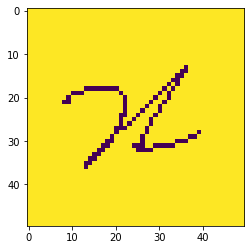

In [45]:
plt.imshow(data[0].resize(50, 50))

In [46]:
output = model(data)

In [47]:
pred = output.max(1, keepdim=True)[1]

In [48]:
pred

tensor([[ 8],
        [31],
        [23],
        [42],
        [ 1],
        [ 7],
        [23],
        [34],
        [ 4],
        [ 7],
        [ 4],
        [31],
        [42],
        [ 8],
        [ 4],
        [ 7],
        [ 4],
        [ 7],
        [32],
        [ 8],
        [36],
        [ 6],
        [32],
        [34],
        [ 4],
        [31],
        [ 7],
        [ 6],
        [15],
        [24],
        [ 7],
        [ 4],
        [36],
        [35],
        [ 7],
        [ 5],
        [ 6],
        [ 7],
        [ 4],
        [ 7],
        [ 4],
        [ 4],
        [26],
        [ 7],
        [48],
        [ 4],
        [ 8],
        [10],
        [23],
        [ 2],
        [23],
        [17],
        [23],
        [23],
        [ 4],
        [23],
        [ 8],
        [ 8],
        [ 8],
        [32],
        [ 4],
        [31],
        [15],
        [36]])

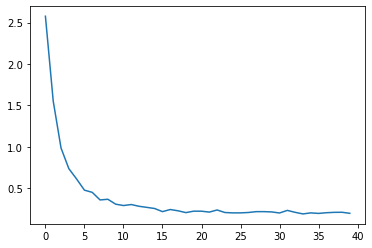

In [54]:
plt.plot(loss)

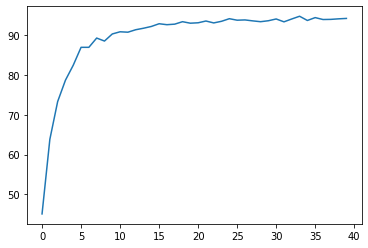

In [55]:
plt.plot(accu)